In [1]:
# https://towardsdatascience.com/land-cover-classification-using-tensorflow-in-python-791036eaa373
# https://github.com/phelber/EuroSAT .. needs to be placed to ./data/2750 !!!!  (90MB's in 27000 files !!)

In [2]:
# CNN Training

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.keras.models import Sequential

In [4]:
# ===============================================================================
# plot styles

sns.set_theme(style="whitegrid")
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Helvetica'

In [5]:
# ===============================================================================
# inspect data

train_data_dir = rf'{os.getcwd()}/data/2750'
#train_data_dir = rf'data/2750'
print(train_data_dir)

C:\Users\mmaresch\OneDrive - Sappi\Development\image_classification/data/2750


In [6]:
print(os.path.exists(train_data_dir))
print(os.getcwd())

True
C:\Users\mmaresch\OneDrive - Sappi\Development\image_classification


                           count  height  width
2750\AnnualCrop             3000      64     64
2750\Forest                 3000      64     64
2750\HerbaceousVegetation   3000      64     64
2750\Highway                2500      64     64
2750\Industrial             2500      64     64
2750\Pasture                2000      64     64
2750\PermanentCrop          2500      64     64
2750\Residential            3000      64     64
2750\River                  2500      64     64
2750\SeaLake                3000      64     64



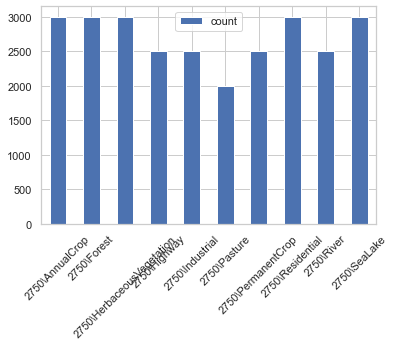

In [7]:
data = {}
img_height, img_width = 0, 0
for path, dirs, files in os.walk(train_data_dir):
    dir_name = path.split('/')[-1]
    if len(files) > 0:
        first_file = files[0]
        file_name, file_ext = first_file.split('.')
        if file_ext == 'jpg':
            image = Image.open(f'{path}/{first_file}')
            img_width, img_height = image.size
            image.close()
            data[dir_name] = {'count': len(files), 'height': img_height, 'width': img_width}

df = pd.DataFrame.from_dict(data, orient='index')
print(df.head(10))
print()
ax = df.plot.bar(y='count', rot=45)

In [8]:
# ===============================================================================
# create training, validation and testing dataset

batch_size = 32
train_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validation_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


In [9]:
# ===============================================================================
# inspect tensorflow training dataset

# get class names and number of classes
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f'number of classes: {num_classes}', class_names)

# retrieve a single batch of 32 images.
image_batch, label_batch = next(iter(train_dataset))

# image_batch = tensor of the shape (32, 64, 64, 3), image shape = 64 x 64 x 3 (height x width x channels)
# label_batch = tensor of the shape (32,), (integer labels)
print(image_batch.shape)
print(label_batch.shape)

# check image value range
first_image = image_batch[0].numpy().astype("uint8")
print(np.min(first_image), np.max(first_image))

number of classes: 10 ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
(32, 64, 64, 3)
(32,)
32 121


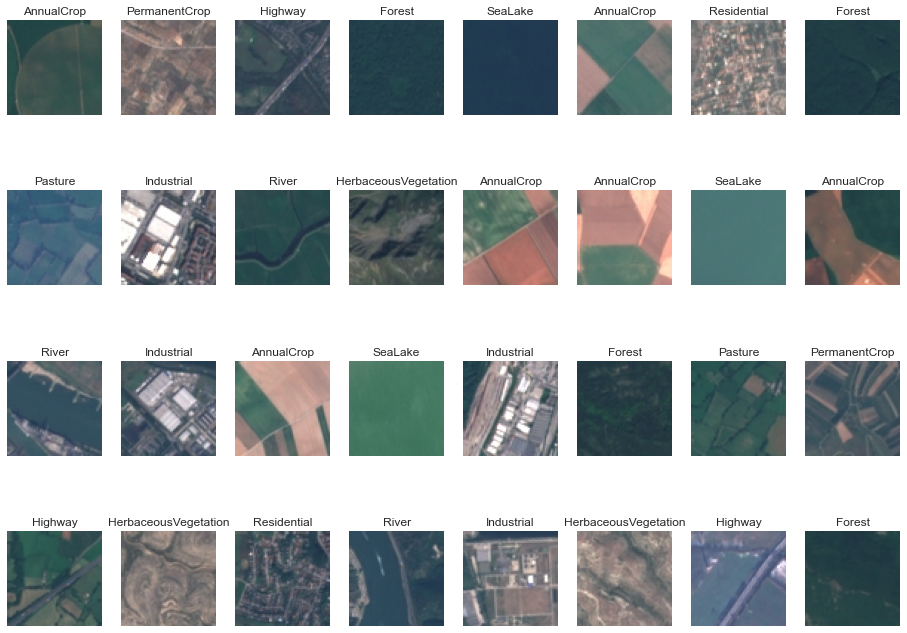

In [10]:
# visualize 10 images from dataset
plt.figure(figsize=(16,12))

max_x=4
max_y=8
for ii in range(max_x*max_y):
    # retrieve ith image from current batch and show
    ax = plt.subplot(max_x, max_y, ii + 1)
    i = ii
    image = image_batch[i].numpy().astype("uint8")
    plt.imshow(image)
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
plt.show()

In [11]:
# ===============================================================================
# cache and prefetch for computational efficiency

# buffered prefetching yields data from disk without incurring I/O blocking
# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch
# Dataset.prefetch overlaps data preprocessing and model execution while training
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# ===============================================================================
# rescale image values into a range of [0,1]

# The RGB channel values are in the [0, 255] range
# Standardization rescales data to have a mean of 0 and a standard deviation of 1 (unit variance).

rescaling_layer = layers.experimental.preprocessing.Rescaling(
    scale=1. / 255,
    input_shape=(img_height, img_width, 3)
)

# rescale data outside of model
rescaled_ds = train_dataset.map(lambda x, y: (rescaling_layer(x), y))
image_batch, labels_batch = next(iter(rescaled_ds))
first_image = image_batch[0].numpy().astype("float32")
print(np.min(first_image), np.max(first_image))

0.1254902 0.50980395


In [13]:
# ===============================================================================
# define data augmentation layer

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [23]:
# ===============================================================================
# build tensorflow sequential convolutional neural network model

model = Sequential([

    # layer 1 - preprocessing layer with convolution and max pooling
    rescaling_layer,
    layers.Conv2D(filters=8, kernel_size=3, padding='same',
                  activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),

    # layer 2 - convolutional layer and max pooling
    layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),

    # layer 3 - convolutional layer and max pooling
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),

    # layer 4 - convolutional layer and max pooling
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    layers.Dropout(rate=0.1),
    layers.Flatten(),

    # layer 5 - dense fully connected layer
    layers.Dense(units=128, activation='relu'),

    # layer 6 - output dense layer
    layers.Dense(num_classes)
])

In [24]:
# compile tensorflow sequential CNN model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# does not work properly above

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.optimizer.learning_rate=0.0005

In [27]:
# ===============================================================================
# train model

epochs = 14
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
model.save(f'{os.getcwd()}/land_cover_model')

Epoch 1/14
675/675 [==============================] - 28s 40ms/step - loss: 1.3699 - accuracy: 0.4863 - val_loss: 1.0317 - val_accuracy: 0.6363
Epoch 2/14
675/675 [==============================] - 29s 43ms/step - loss: 0.9771 - accuracy: 0.6443 - val_loss: 0.8992 - val_accuracy: 0.6943
Epoch 3/14
675/675 [==============================] - 29s 43ms/step - loss: 0.8370 - accuracy: 0.6958 - val_loss: 0.7755 - val_accuracy: 0.7211
Epoch 4/14
675/675 [==============================] - 30s 44ms/step - loss: 0.7473 - accuracy: 0.7256 - val_loss: 0.7002 - val_accuracy: 0.7522
Epoch 5/14
675/675 [==============================] - 33s 49ms/step - loss: 0.6891 - accuracy: 0.7494 - val_loss: 0.6523 - val_accuracy: 0.7585
Epoch 6/14
675/675 [==============================] - 30s 45ms/step - loss: 0.6439 - accuracy: 0.7677 - val_loss: 0.5944 - val_accuracy: 0.7811
Epoch 7/14
675/675 [==============================] - 30s 45ms/step - loss: 0.5896 - accuracy: 0.7879 - val_loss: 0.6432 - val_accuracy:

INFO:tensorflow:Assets written to: C:\Users\mmaresch\OneDrive - Sappi\Development\image_classification/land_cover_model\assets


INFO:tensorflow:Assets written to: C:\Users\mmaresch\OneDrive - Sappi\Development\image_classification/land_cover_model\assets


In [28]:
# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_13 (ModuleWra (None, 64, 64, 3)         0         
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 64, 64, 8)         224       
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 32, 32, 8)         0         
_________________________________________________________________
module_wrapper_16 (ModuleWra (None, 32, 32, 16)        1168      
_________________________________________________________________
module_wrapper_17 (ModuleWra (None, 16, 16, 16)        0         
_________________________________________________________________
module_wrapper_18 (ModuleWra (None, 16, 16, 32)        4640      
_________________________________________________________________
module_wrapper_19 (ModuleWra (None, 8, 8, 32)         

In [29]:
# ===============================================================================
# visualize training metrics

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

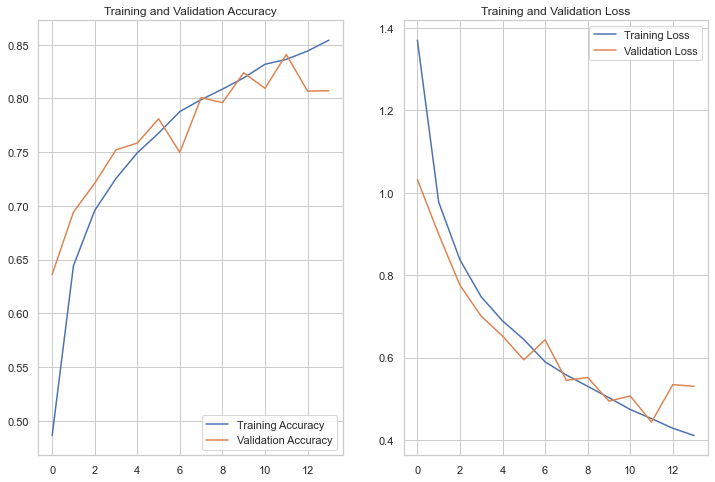

In [32]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()